Data loading

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Define column names
column_names = ['user_id', 'item_id', 'rating']

path = '../data'
interaction = pd.read_csv(path + '/ratings.dat', sep='::', names=column_names, usecols=['user_id', 'item_id', 'rating'])
interaction['implicit_rating'] = np.where(interaction['rating'] >= 3, 1, 0)
interaction = interaction.drop(labels='rating', axis=1)
interaction

C:\Users\admin\AppData\Local\Temp\ipykernel_9068\1018464135.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  interaction = pd.read_csv(path + '/ratings.dat', sep='::', names=column_names, usecols=['user_id', 'item_id', 'rating'])


,user_id,item_id,implicit_rating
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1
...,...,...,...
1000204,6040,1091,0
1000205,6040,1094,1
1000206,6040,562,1
1000207,6040,1096,1


Data supplement

In [18]:
user_engagement = interaction.groupby(by='user_id')['implicit_rating'].sum().reset_index()
user_engagement.columns = ['user_id', 'user_engagement']

interaction = pd.merge(interaction, user_engagement, on='user_id', how='left')
interaction

,user_id,item_id,implicit_rating,user_engagement
0,1,1193,1,53
1,1,661,1,53
2,1,914,1,53
3,1,3408,1,53
4,1,2355,1,53
...,...,...,...,...
1000204,6040,1091,0,276
1000205,6040,1094,1,276
1000206,6040,562,1,276
1000207,6040,1096,1,276


In [19]:
movie_popularity = interaction.groupby(by='item_id')['implicit_rating'].sum().reset_index()
movie_popularity.columns = ['item_id', 'movie_popularity']

interaction = pd.merge(interaction, movie_popularity, on='item_id', how='left')
interaction

,user_id,item_id,implicit_rating,user_engagement,movie_popularity
0,1,1193,1,53,1680
1,1,661,1,53,443
2,1,914,1,53,611
3,1,3408,1,53,1223
4,1,2355,1,53,1599
...,...,...,...,...,...
1000204,6040,1091,0,276,237
1000205,6040,1094,1,276,1100
1000206,6040,562,1,276,425
1000207,6040,1096,1,276,316


Data split

In [20]:
# Encode user_id and item_id
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

interaction['user_id'] = user_encoder.fit_transform(interaction['user_id'])
interaction['item_id'] = movie_encoder.fit_transform(interaction['item_id'])
    
# Prepare features (X) and labels (y)
X = interaction[['user_id', 'item_id', 'user_engagement', 'movie_popularity']]
y = interaction['implicit_rating']
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,user_id,item_id,user_engagement,movie_popularity
416292,2506,2821,751,407
683230,4086,2633,38,269
2434,18,443,214,1941
688533,4117,2599,194,1290
472584,2906,759,654,304
...,...,...,...,...
259178,1585,1005,410,696
365838,2128,2495,264,1061
131932,853,2886,378,218
671155,4032,3246,596,486


Investigate model under n_estimator settings

In [32]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time

X_train['user_id'] = X_train['user_id'].astype('category')
X_train['item_id'] = X_train['item_id'].astype('category')
X_test['user_id'] = X_test['user_id'].astype('category')
X_test['item_id'] = X_test['item_id'].astype('category')

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=['user_id', 'item_id'], weight=[5 if i == 1 else 1 for i in y_train], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, categorical_feature=['user_id', 'item_id'], reference=lgb_train, free_raw_data=False)

n_estimators = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
train_times_n = []
rmses_n = []

for n_estimator in n_estimators:
    params = {
    'objective': 'binary',       # Suitable for recommendation tasks
    'metric': 'rmse',                # Root Mean Squared Error as evaluation metric
    'n_estimators': n_estimator,
    'learning_rate': 0.1,
    'num_leaves': 50,                # Controls complexity
    'max_depth': 10,
    'verbose': -1
    }

    start_train_time = time.time()

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=200,             # Maximum rounds
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test']
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    end_train_time = time.time()
    train_time = (end_train_time - start_train_time)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE@{n_estimator}: {rmse}")
    print(f"Execution time@{n_estimator}: {train_time}")
    print("---------------------------------------------")

    train_times_n.append(train_time)
    rmses_n.append(rmse)

d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@10: 0.37389154776270006
Execution time@10: 0.8919858932495117
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@20: 0.3692024894426633
Execution time@20: 0.9046852588653564
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@50: 0.3643461511141935
Execution time@50: 2.175361156463623
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@100: 0.3603007938848248
Execution time@100: 3.388288736343384
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@150: 0.3576293242168453
Execution time@150: 4.576566219329834
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@200: 0.35572615836340876
Execution time@200: 6.067254543304443
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@250: 0.354102192224145
Execution time@250: 7.839223384857178
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@300: 0.35284339185402624
Execution time@300: 9.670182704925537
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@350: 0.35162408888828944
Execution time@350: 10.416331768035889
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@400: 0.35053751901744784
Execution time@400: 12.141332149505615
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@450: 0.3494617101236886
Execution time@450: 13.782890558242798
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@500: 0.34869822432874253
Execution time@500: 15.727946758270264
---------------------------------------------


Line graph

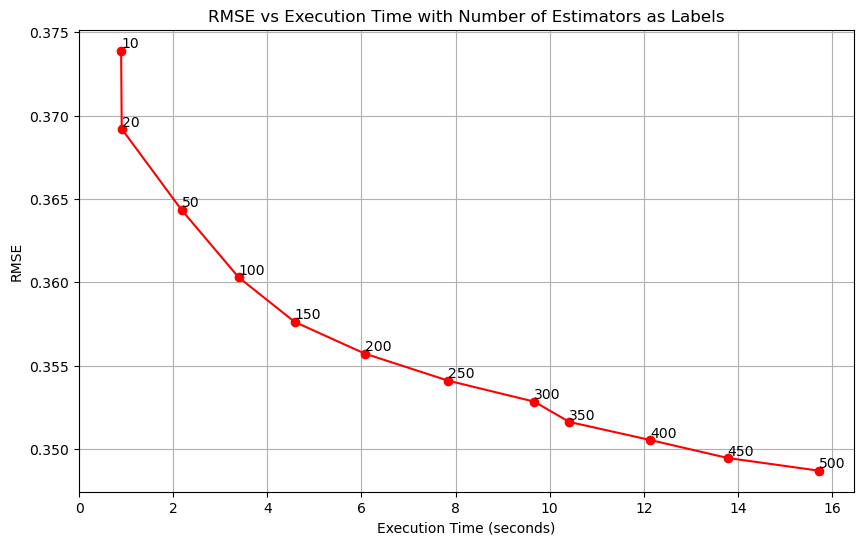

In [33]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times_n, rmses_n, marker='o', color='r', linestyle='-')

# Adding labels for each point to show n_estimators
for i, n_estimator in enumerate(n_estimators):
    plt.text(train_times_n[i], rmses_n[i], str(n_estimator), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times_n)
plt.xticks(np.arange(0, max_time + 1, 2))  # Adjusting to show every second

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Number of Estimators as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

Bar plot

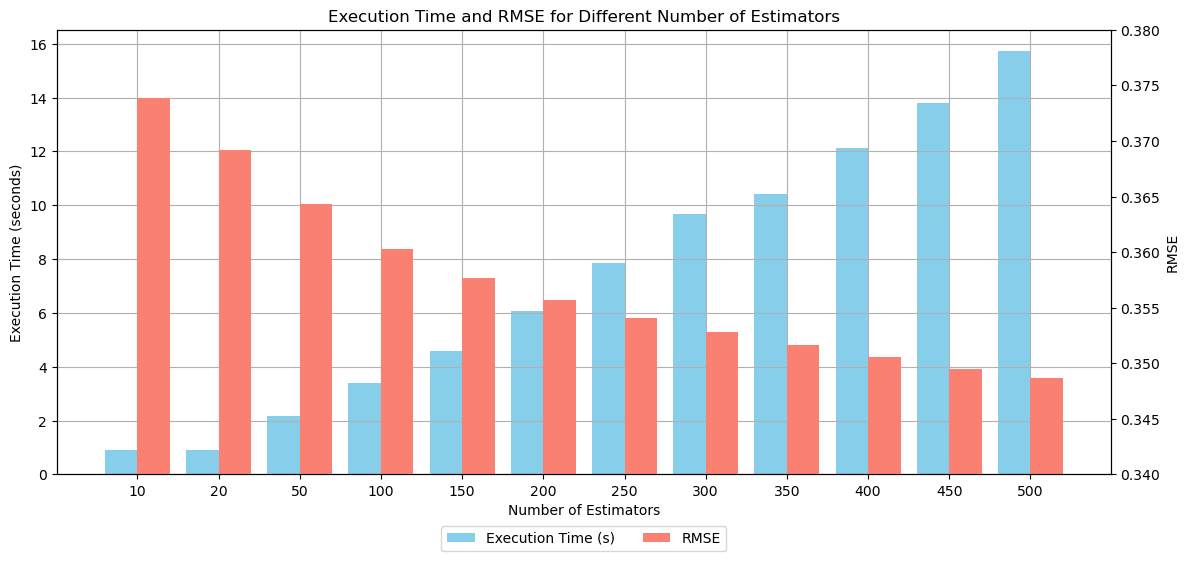

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(n_estimators)) - 0.2, train_times_n, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Number of Estimators")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(n_estimators)) + 0.2, rmses_n, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(n_estimators)), n_estimators)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.34, 0.38)

# Title and grid
plt.title("Execution Time and RMSE for Different Number of Estimators")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


Investigate model under max_depth settings

In [24]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time

X_train['user_id'] = X_train['user_id'].astype('category')
X_train['item_id'] = X_train['item_id'].astype('category')
X_test['user_id'] = X_test['user_id'].astype('category')
X_test['item_id'] = X_test['item_id'].astype('category')

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=['user_id', 'item_id'], weight=[5 if i == 1 else 1 for i in y_train], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, categorical_feature=['user_id', 'item_id'], reference=lgb_train, free_raw_data=False)

max_depths = [1, 2, 4, 6, 8, 10, 12, 15, 20]
train_times_d = []
rmses_d = []

for max_depth in max_depths:
    params = {
    'objective': 'binary',       # Suitable for recommendation tasks
    'metric': 'rmse',                # Root Mean Squared Error as evaluation metric
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 50,                # Controls complexity
    'max_depth': max_depth,
    'verbose': -1
    }

    start_train_time = time.time()

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=200,             # Maximum rounds
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test']
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    end_train_time = time.time()
    train_time = (end_train_time - start_train_time)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE@{max_depth}: {rmse}")
    print(f"Execution time@{max_depth}: {train_time}")
    print("---------------------------------------------")

    train_times_d.append(train_time)
    rmses_d.append(rmse)

d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@1: 0.3785858417331261
Execution time@1: 1.4654536247253418
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@2: 0.37326793098126004
Execution time@2: 1.232790470123291
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@4: 0.3680699260803118
Execution time@4: 1.7832350730895996
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@6: 0.36439791321175236
Execution time@6: 2.182220220565796
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@8: 0.36206488776427015
Execution time@8: 2.650641441345215
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@10: 0.3603007938848248
Execution time@10: 3.057429313659668
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@12: 0.35908422048559185
Execution time@12: 3.232168674468994
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@15: 0.3576946773714848
Execution time@15: 3.7940762042999268
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@20: 0.3558477974644491
Execution time@20: 4.505892992019653
---------------------------------------------


Line graph

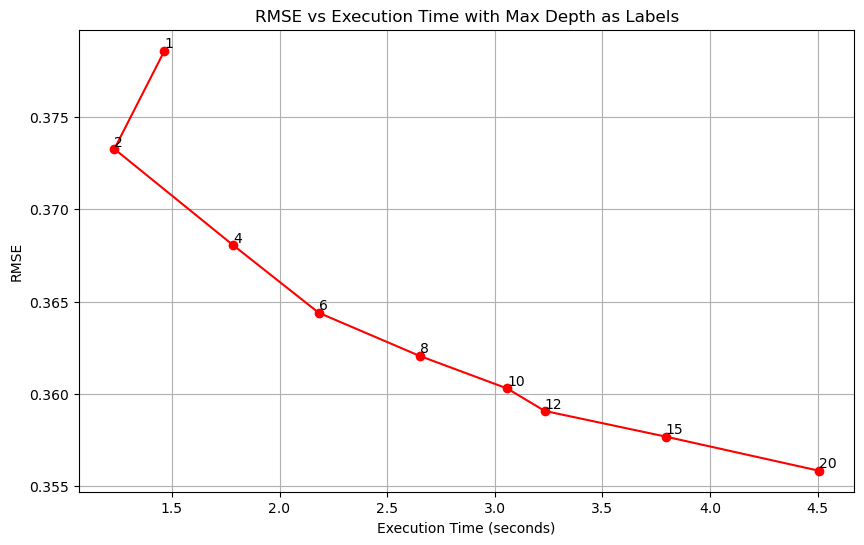

In [25]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times_d, rmses_d, marker='o', color='r', linestyle='-')

# Adding labels for each point to show max_depth
for i, max_depth in enumerate(max_depths):
    plt.text(train_times_d[i], rmses_d[i], str(max_depth), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times_d)
#plt.xticks(np.arange(0, max_time + 1, 1))  # Adjusting to show every second

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Max Depth as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

Bar plot

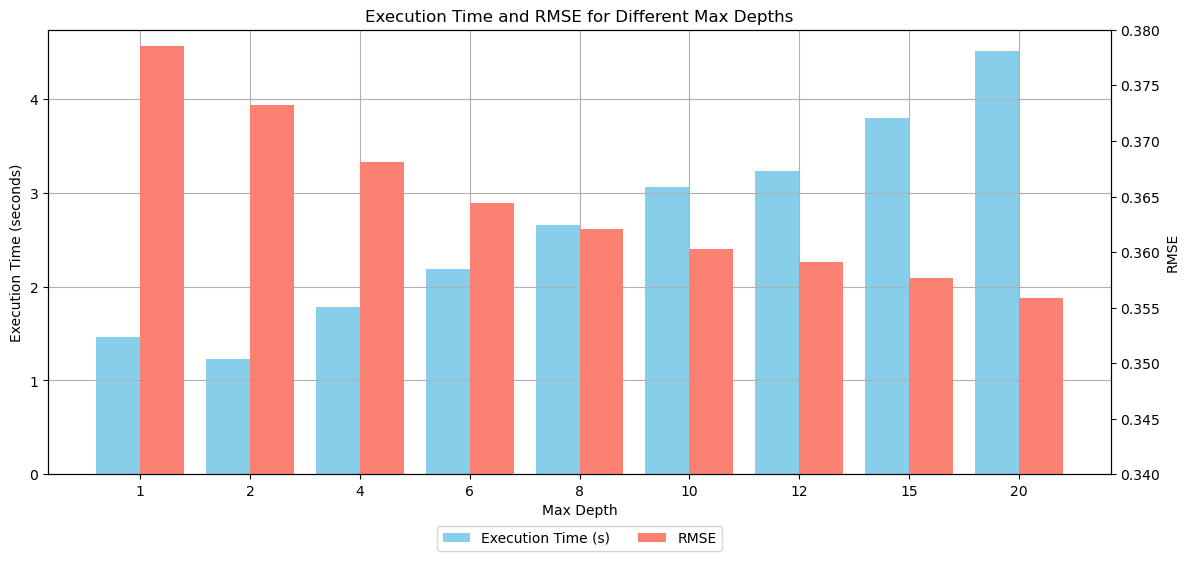

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(max_depths)) - 0.2, train_times_d, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(max_depths)) + 0.2, rmses_d, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(max_depths)), max_depths)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.34, 0.38)

# Title and grid
plt.title("Execution Time and RMSE for Different Max Depths")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Investigate model under regularization settings

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time

X_train['user_id'] = X_train['user_id'].astype('category')
X_train['item_id'] = X_train['item_id'].astype('category')
X_test['user_id'] = X_test['user_id'].astype('category')
X_test['item_id'] = X_test['item_id'].astype('category')

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=['user_id', 'item_id'], weight=[5 if i == 1 else 1 for i in y_train], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, categorical_feature=['user_id', 'item_id'], reference=lgb_train, free_raw_data=False)

l1s = [0, 0.5, 1.0, 2.0, 5.0]
l2s = [0, 0.5, 1.0, 2.0, 5.0]
train_times_r = []
rmses_r = {}

for l1 in l1s:
    for l2 in l2s:
        params = {
        'objective': 'binary',       # Suitable for recommendation tasks
        'metric': 'rmse',                # Root Mean Squared Error as evaluation metric
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 50,                # Controls complexity
        'max_depth': 10,
        'lambda_l1': l1,
        'lambda_l2': l2,
        'verbose': -1
        }

        #start_train_time = time.time()

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=200,             # Maximum rounds
            valid_sets=[lgb_train, lgb_test],
            valid_names=['train', 'test']
        )

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        #end_train_time = time.time()
        #train_time = (end_train_time - start_train_time)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE@{l1}/{l2}: {rmse}")
        #print(f"Execution time@{max_depth}: {train_time}")
        print("---------------------------------------------")

        #train_times.append(train_time)
        rmses_r[(l1, l2)] = rmse

d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0/0: 0.3603007938848248
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0/0.5: 0.36028056130796554
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0/1.0: 0.36038367180639214
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0/2.0: 0.3604549202163441
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0/5.0: 0.3605508953178624
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0.5/0: 0.36040322784025297
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0.5/0.5: 0.3603801805877855
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0.5/1.0: 0.3604438790904735
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0.5/2.0: 0.36033763680839465
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@0.5/5.0: 0.36040878262915643
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@1.0/0: 0.3604685560276964
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@1.0/0.5: 0.36048984906655374
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@1.0/1.0: 0.3603047890452731
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@1.0/2.0: 0.360679494689008
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@1.0/5.0: 0.3605223858955782
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@2.0/0: 0.36052719815262796
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@2.0/0.5: 0.3604180622350794
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@2.0/1.0: 0.3604269857938168
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@2.0/2.0: 0.3605503481090806
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@2.0/5.0: 0.3606804095687765
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@5.0/0: 0.3604804596937974
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@5.0/0.5: 0.3605837425754703
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@5.0/1.0: 0.36054627742911954
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@5.0/2.0: 0.36061958467215216
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@5.0/5.0: 0.3607659758101513
---------------------------------------------


Heatmap

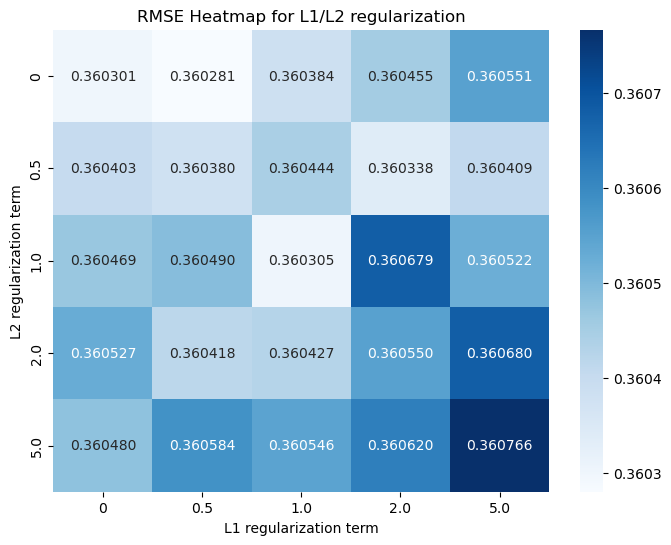

In [28]:
rmse_matrix = np.array([[rmses_r[(l1, l2)] for l2 in l2s] for l1 in l1s])

import seaborn as sns

# Plot the heatmap using seaborn
plt.figure(figsize=(8, 6))
ax = sns.heatmap(rmse_matrix, annot=True, fmt=".6f", cmap="Blues", xticklabels=l1s, yticklabels=l2s)

# Add labels and title
ax.set_xlabel("L1 regularization term")
ax.set_ylabel("L2 regularization term")
ax.set_title("RMSE Heatmap for L1/L2 regularization")

# Show plot
plt.show()

Investigate model under objective settings

In [29]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time

X_train['user_id'] = X_train['user_id'].astype('category')
X_train['item_id'] = X_train['item_id'].astype('category')
X_test['user_id'] = X_test['user_id'].astype('category')
X_test['item_id'] = X_test['item_id'].astype('category')

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=['user_id', 'item_id'], weight=[5 if i == 1 else 1 for i in y_train], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, categorical_feature=['user_id', 'item_id'], reference=lgb_train, free_raw_data=False)

metrics = ['regression', 'poisson', 'binary']
train_times_o = []
rmses_o = []

for metric in metrics:
    params = {
    'objective': metric,       # Suitable for recommendation tasks
    'metric': 'rmse',                # Root Mean Squared Error as evaluation metric
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 50,                # Controls complexity
    'max_depth': 10,
    'lambda_l1': 1.0,
    'lambda_l2': 0.0,
    'verbose': -1
    }

    start_train_time = time.time()

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=200,             # Maximum rounds
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test']
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    end_train_time = time.time()
    train_time = (end_train_time - start_train_time)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE@{metric}: {rmse}")
    print(f"Execution time@{metric}: {train_time}")
    print("---------------------------------------------")

    train_times_o.append(train_time)
    rmses_o.append(rmse)

d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@regression: 0.36186120412524836
Execution time@regression: 3.1385228633880615
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@poisson: 0.36558404786494064
Execution time@poisson: 3.2098026275634766
---------------------------------------------


d:\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE@binary: 0.3604685560276964
Execution time@binary: 3.1598122119903564
---------------------------------------------


Bar plot

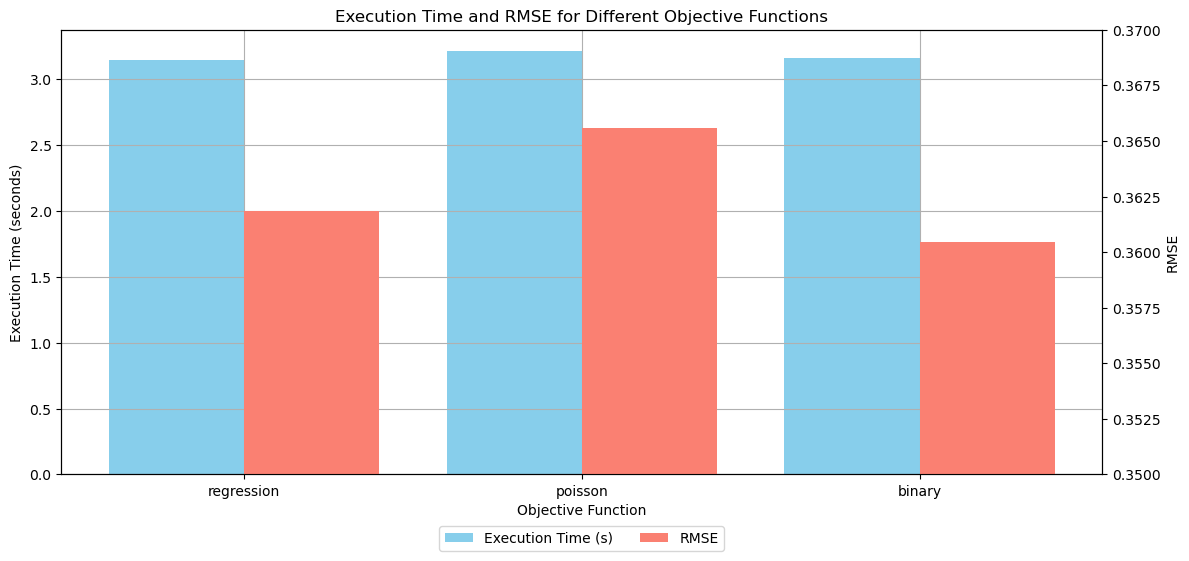

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(metrics)) - 0.2, train_times_o, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Objective Function")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(metrics)) + 0.2, rmses_o, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(metrics)), metrics)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.35, 0.37)

# Title and grid
plt.title("Execution Time and RMSE for Different Objective Functions")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Calculate extra evaluation metrics (Recall@5, Precision@5)

In [31]:
from sklearn.metrics import precision_score, recall_score

# Clone X_test
X_test_check = X_test.copy()

X_test_check['pred_score'] = model.predict(X_test_check, num_iteration=model.best_iteration)
X_test_check['actual_interaction'] = y_test.values

# **Top 5 Precision and Recall Calculation**
# Group by user and get top 5 predictions for each user
top_5_recs = X_test_check.sort_values(['user_id', 'pred_score'], ascending=[True, False]) \
                   .groupby('user_id').head(5)

# Calculate Precision@5 and Recall@5
precision_at_5 = top_5_recs.groupby('user_id').apply(
    lambda x: precision_score(x['actual_interaction'], (x['pred_score'] >= np.percentile(x['pred_score'], 80)).astype(int))
).mean()

recall_at_5 = top_5_recs.groupby('user_id').apply(
    lambda x: recall_score(x['actual_interaction'], (x['pred_score'] >= np.percentile(x['pred_score'], 80)).astype(int))
).mean()

print(f"Precision@5: {precision_at_5}")
print(f"Recall@5: {recall_at_5}")

d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

Precision@5: 0.9632328585624379
Recall@5: 0.22000386441426523
